In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.signal import medfilt

In [19]:
# Store log files here
log_files = {}

## Load data

In [20]:
def smooth_curve(x, y):
    # Halfwidth of our smoothing convolution
    halfwidth = min(31, int(np.ceil(len(x) / 30)))
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2 * k + 1), mode='valid') / \
        np.convolve(np.ones_like(y), np.ones(2 * k + 1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo) / 1e3)), 1)
    return xsmoo[::downsample], ysmoo[::downsample]

def fix_point(x, y, interval):
    np.insert(x, 0, 0)
    np.insert(y, 0, 0)

    fx, fy = [], []
    pointer = 0

    ninterval = int(max(x) / interval + 1)

    for i in range(ninterval):
        tmpx = interval * i

        while pointer + 1 < len(x) and tmpx > x[pointer + 1]:
            pointer += 1

        if pointer + 1 < len(x):
            alpha = (y[pointer + 1] - y[pointer]) / \
                (x[pointer + 1] - x[pointer])
            tmpy = y[pointer] + alpha * (tmpx - x[pointer])
            fx.append(tmpx)
            fy.append(tmpy)

    return fx, fy

def load_data(indir, bin_size, smooth):
    datas = []
    infiles = glob.glob(os.path.join(indir, '*.monitor.csv'))

    for inf in infiles:
        with open(inf, 'r') as f:
            f.readline()
            f.readline()
            for line in f:
                tmp = line.split(',')
                t_time = float(tmp[2])
                tmp = [t_time, int(tmp[1]), float(tmp[0])]
                datas.append(tmp)

    datas = sorted(datas, key=lambda d_entry: d_entry[0])
    result = []
    timesteps = 0
    for i in range(len(datas)):
        result.append([timesteps, datas[i][-1]])
        # result.append([timesteps, datas[i][1]])  # take the number of steps, not the reward
        timesteps += datas[i][1]

    if len(result) < bin_size:
        return [None, None]

    x, y = np.array(result)[:, 0], np.array(result)[:, 1]

    if smooth == 1:
        x, y = smooth_curve(x, y)

    if smooth == 2:
        y = medfilt(y, kernel_size=9)

    x, y = fix_point(x, y, bin_size)
    return [x, y]

# Plot

In [50]:
def plot(exp_dirs, super_title, num_steps=10e6, bin_size=100, smooth=1):
    
    data = {}
    for f in exp_dirs:
        print(f)
        data[f] = load_data(f, bin_size, smooth)
    
    fig = plt.figure(figsize=(12,9))
    for k, v in data.items():
        if v[0] is None or v[1] is None:
            continue
        plt.plot(v[0], v[1], label="{}".format(k))

    tick_fractions = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
    ticks = tick_fractions * num_steps
    tick_names = ["{:.0e}".format(tick) for tick in ticks]
    plt.xticks(ticks, tick_names)
    plt.xlim(0, num_steps)

    plt.xlabel('Number of Frames')
    plt.ylabel('Rewards')
    plt.suptitle(super_title)
    plt.title('Reward Over Time')
    plt.legend(loc=0)
    plt.show()
    plt.draw()
    plt.close(fig)
    
    
def plot_a2oc_terminations(exp_files, super_title, num_steps=10e6, bin_size=100, smooth=1):
    def load_data(f, bin_size, smooth):
        y = pd.read_csv(f, header=None)
        x, y = y[0], y[1]
        if smooth:
            if len(x) < bin_size:
                return [None, None]
            else:
                return smooth_curve(x, y)
    
    data = {}
    for f in exp_files:
        print(f)
        data[f] = load_data(f, bin_size, smooth)
    
    fig = plt.figure(figsize=(24,18))
    for k, v in data.items():
        if v[0] is None or v[1] is None:
            continue
        plt.plot(v[0], v[1], label="{}".format(k))

    tick_fractions = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
    ticks = tick_fractions * num_steps
    tick_names = ["{:.0e}".format(tick) for tick in ticks]
    plt.xticks(ticks, tick_names)
    plt.xlim(0, num_steps)

    plt.xlabel('Number of Frames')
    plt.ylabel('Probability of Termination')
    plt.suptitle(super_title)
    plt.title('Probability of Termination Over Time')
    plt.legend(loc=0)
    plt.show()
    plt.draw()
    plt.close(fig)
    
def plot_options_preference(file, super_title, num_steps=10e6):
    y = pd.read_csv(file, header=None)
    x = y[0]
    y = y.drop(y.columns[0], axis=1)
    y = y.divide(y.sum(axis=1), axis=0).T

    fig, ax = plt.subplots()
    ax.stackplot(x, y, labels=[str(i) for i in range(len(y))])
    ax.legend(loc=2)

    tick_fractions = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
    ticks = tick_fractions * num_steps
    tick_names = ["{:.0e}".format(tick) for tick in ticks]
    plt.xticks(ticks, tick_names)
    plt.xlim(0, num_steps)

    plt.yticks(np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    plt.ylim(0, 1.0)

    plt.ylabel('Proportion of Steps With Option')
    plt.xlabel('Number of Frames')
    plt.suptitle(super_title)
    plt.title('Preference of Options Over Time')
    plt.show()
    plt.draw()
    plt.close(fig)
    

In [51]:
folder = "/Users/rsailer/Downloads/save_files"

filter_string = 'BreakoutNoFrameskip'

exp_dirs = os.listdir(folder)
exp_dirs = sorted([os.path.join(folder,f) for f in exp_dirs if os.path.isdir(os.path.join(folder,f))])

# Filter.
exp_dirs = [f for f in exp_dirs if filter_string in f]

for i in range(len(exp_dirs)):
    print("{}, {}".format(i, exp_dirs[i]))

exp_dirs = exp_dirs[:8:2]

0, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2c
1, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.0
2, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.005
3, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.01
4, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.015
5, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.02
6, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.025
7, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.03
8, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.0
9, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.005
10, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.01
11, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.015
12, /Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.02
13, /Users/rsailer/Downloads/save_files/

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2c
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.005
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.015
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.025


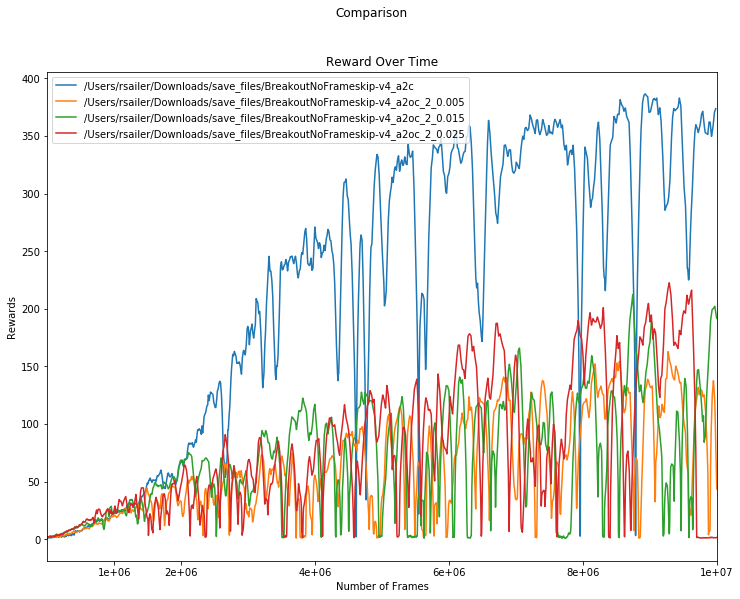

<Figure size 432x288 with 0 Axes>

In [52]:
plot(exp_dirs, "Comparison", bin_size=100, smooth=1)

# Plot Termination Probabilities

In [53]:
for game in ['Breakout', 'Amidar']:
    termination_logs = os.listdir(folder)
    termination_logs = sorted([os.path.join(folder,f) for f in termination_logs if os.path.isdir(os.path.join(folder,f))])
    termination_logs = [f for f in termination_logs if game in f and 'a2oc' in f]
    termination_logs = termination_logs[:8:2]
    termination_logs = [os.path.join(f, 'log_term_prob.csv') for f in termination_logs]

    log_files[game + '_term'] = termination_logs

# Breakout

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.0/log_term_prob.csv
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.01/log_term_prob.csv
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.02/log_term_prob.csv
/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.03/log_term_prob.csv


TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

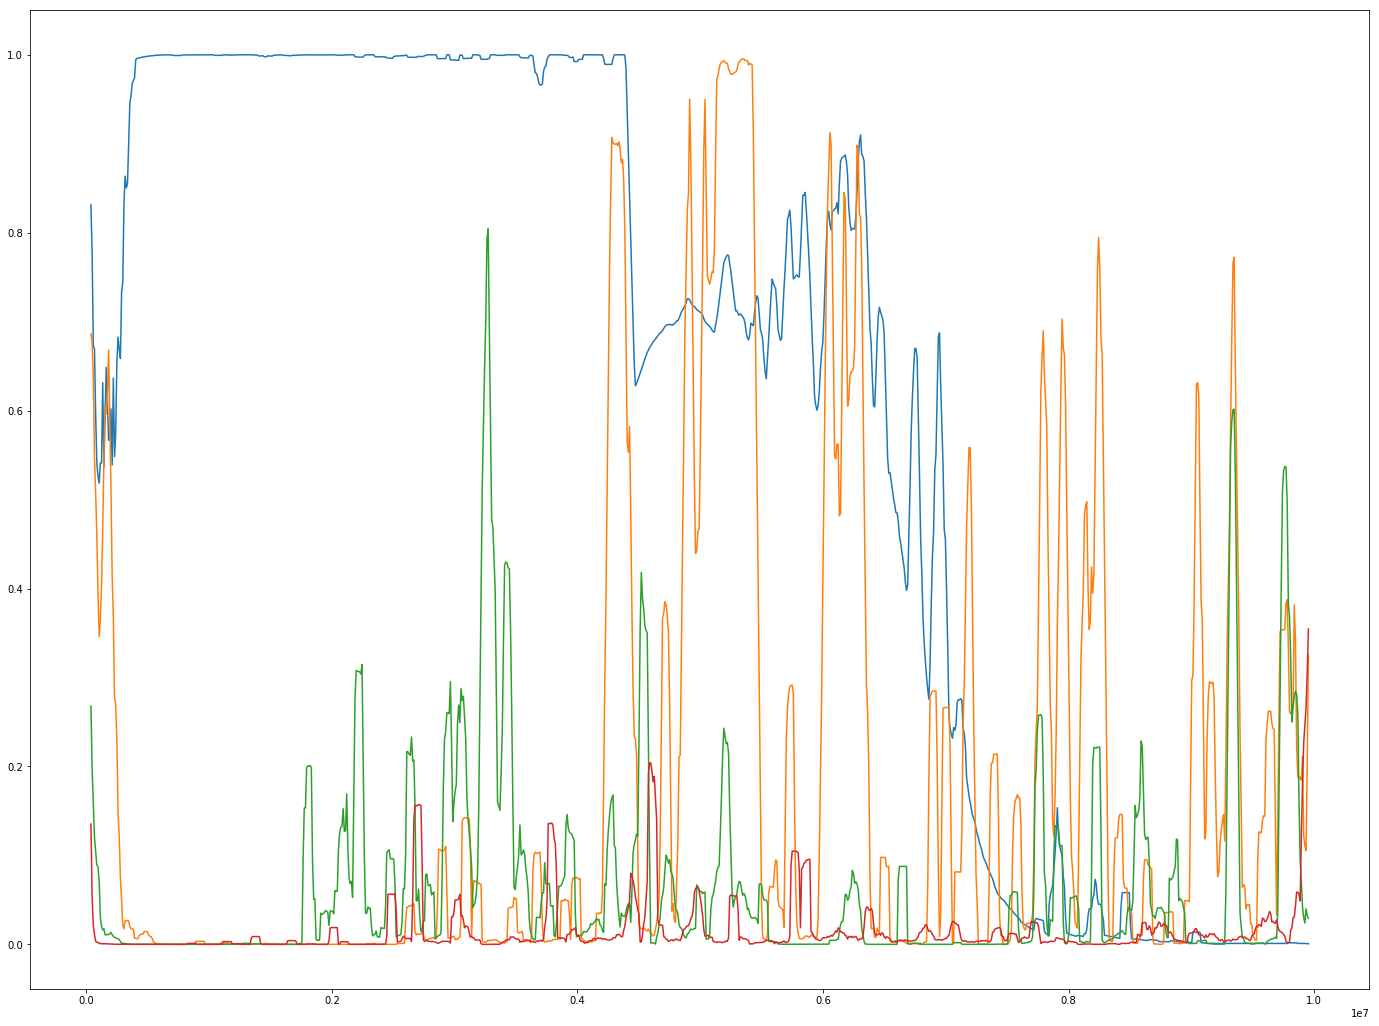

In [54]:
plot_a2oc_terminations(log_files['Breakout_term'], 'Termination over time', 'Termination')

# Amidar

In [ ]:
plot_a2oc(log_files['Amidar_term'], 'Termination over time', 'Termination')

In [9]:
for game in ['Breakout', 'Amidar']:
    termination_logs = os.listdir(folder)
    termination_logs = sorted([os.path.join(folder,f) for f in termination_logs if os.path.isdir(os.path.join(folder,f))])
    termination_logs = [f for f in termination_logs if game in f and 'a2oc' in f]
    termination_logs = [os.path.join(f, 'log_options.csv') for f in termination_logs]

    log_files[game + '_options'] = termination_logs


In [10]:
log_files['Breakout_options']

['/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.0/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.005/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.01/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.015/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.02/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.025/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.03/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.0/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.005/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.01/log_options.csv',
 '/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.015/log_options.cs

# Breakout Option Preference

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.0/log_options.csv


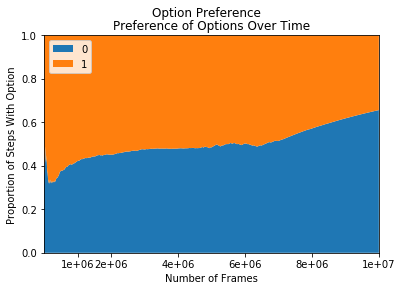

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

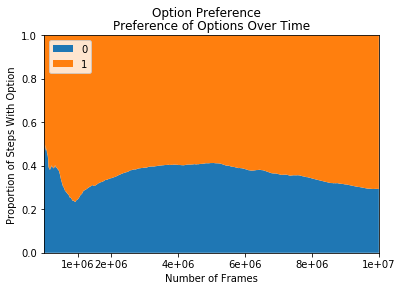

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

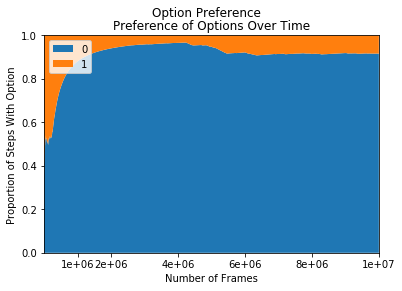

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

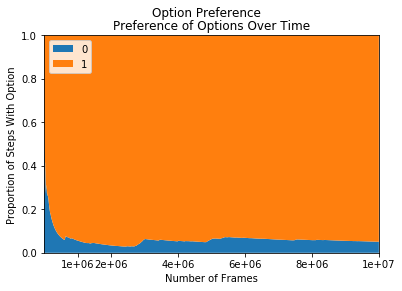

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

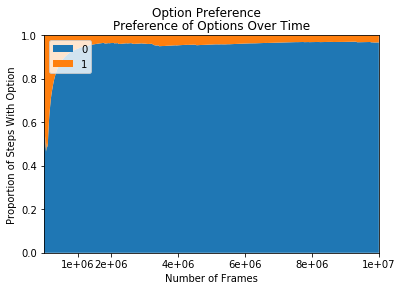

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

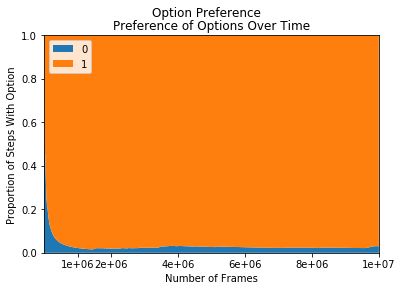

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_2_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

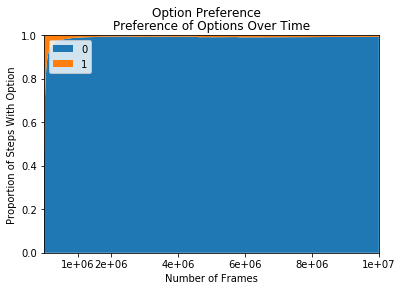

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.0/log_options.csv


<Figure size 432x288 with 0 Axes>

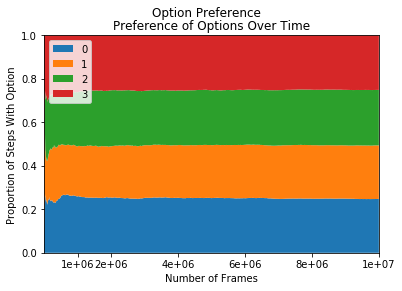

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

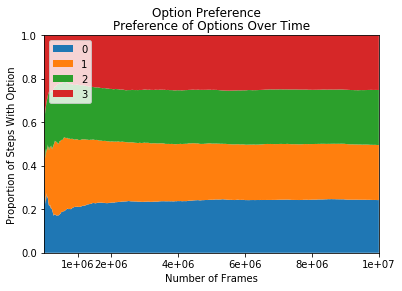

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

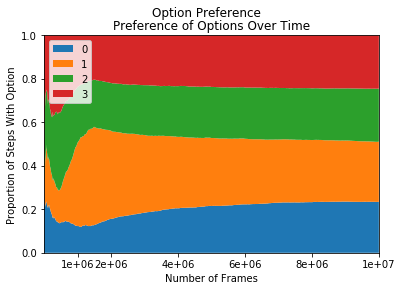

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

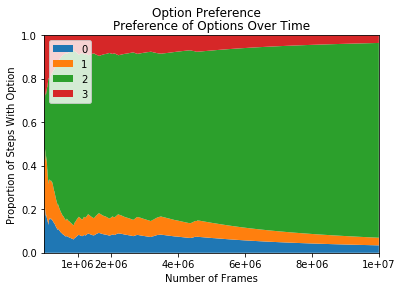

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

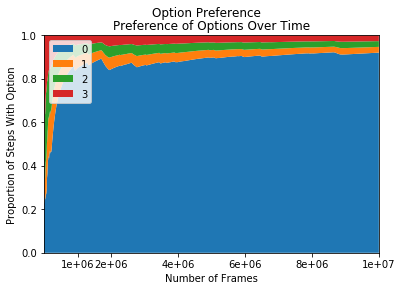

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

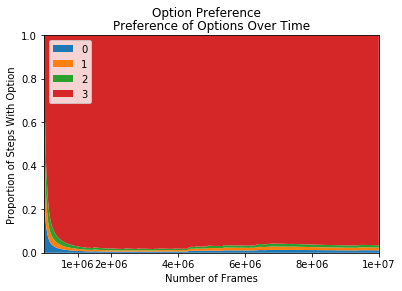

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_4_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

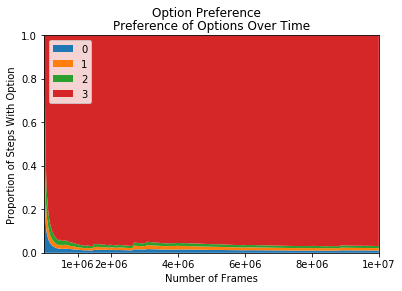

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.0/log_options.csv


<Figure size 432x288 with 0 Axes>

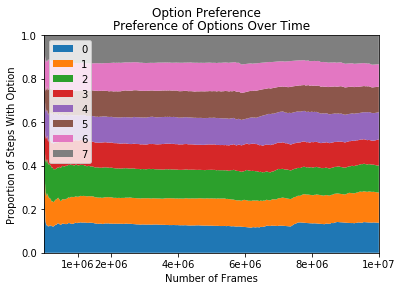

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

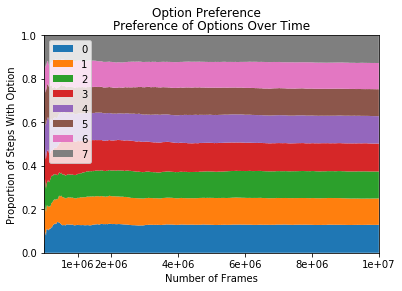

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

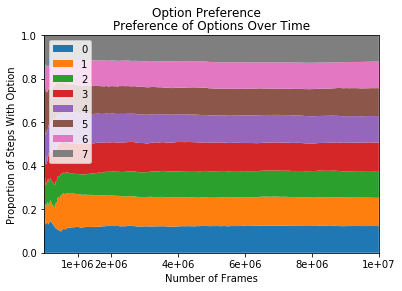

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

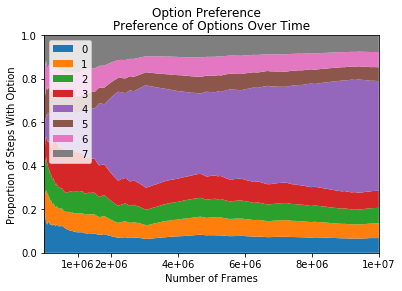

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

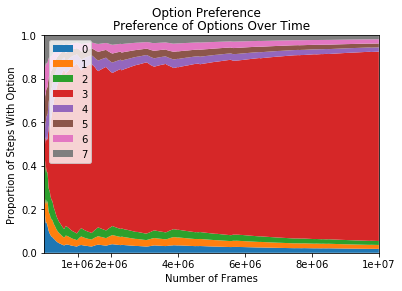

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

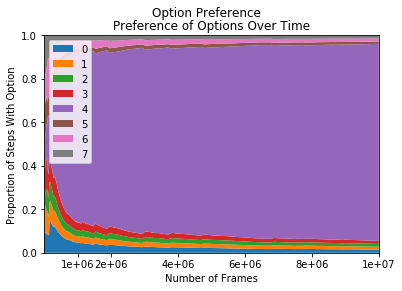

/Users/rsailer/Downloads/save_files/BreakoutNoFrameskip-v4_a2oc_8_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

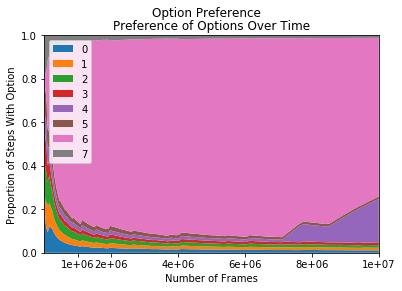

<Figure size 432x288 with 0 Axes>

In [11]:
for f in log_files['Breakout_options']:
    print(f)
    plot_options_preference(f, "Option Preference")

# Amidar Option Preference

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.0/log_options.csv


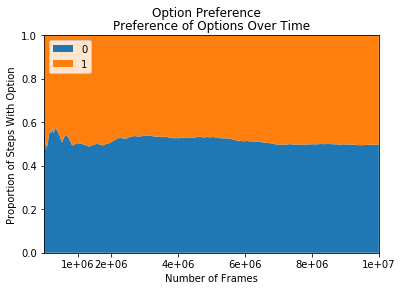

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

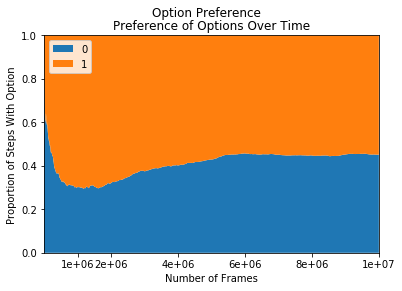

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

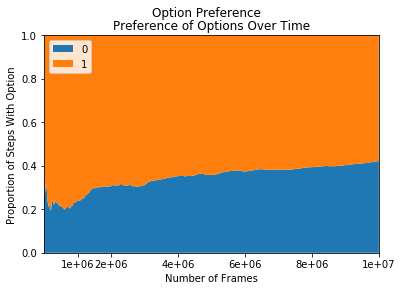

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

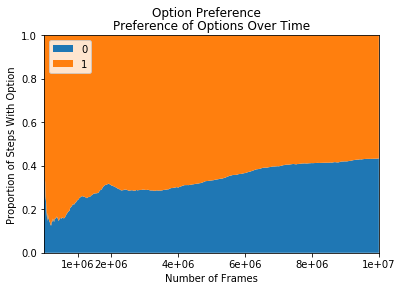

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

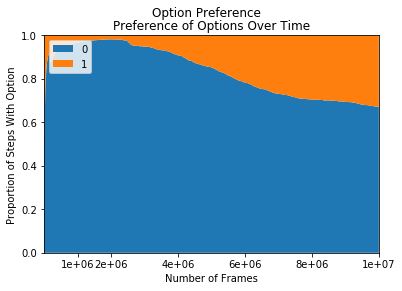

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

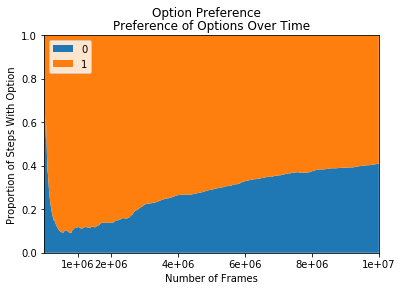

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_2_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

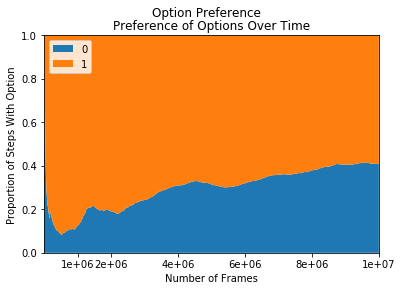

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.0/log_options.csv


<Figure size 432x288 with 0 Axes>

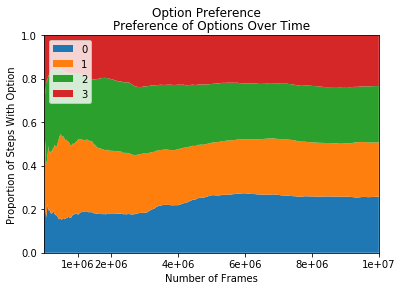

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

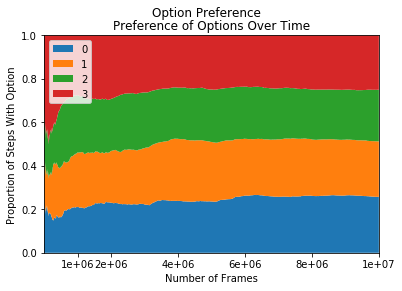

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

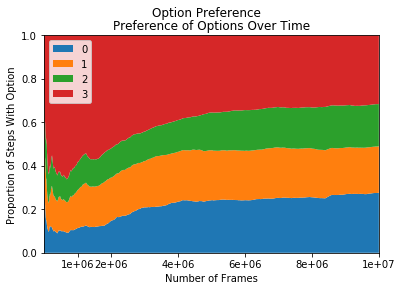

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

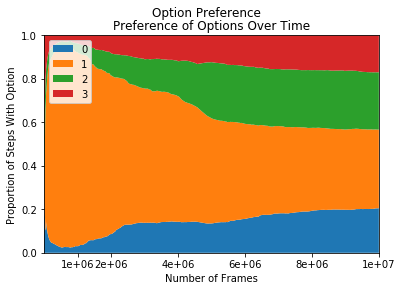

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

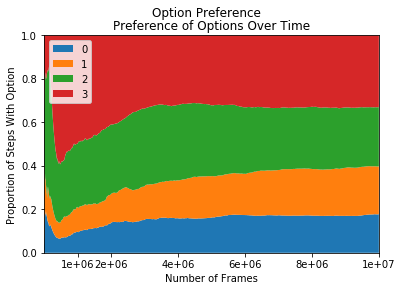

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

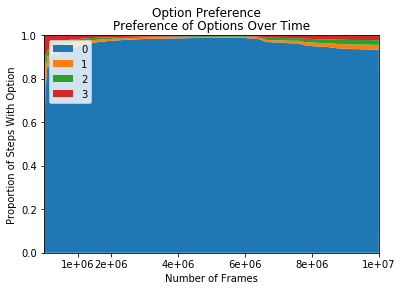

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_4_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

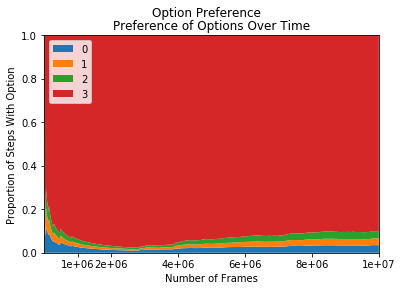

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.0/log_options.csv


<Figure size 432x288 with 0 Axes>

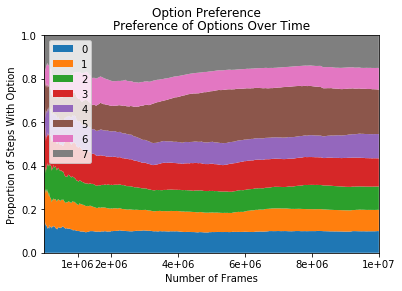

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.005/log_options.csv


<Figure size 432x288 with 0 Axes>

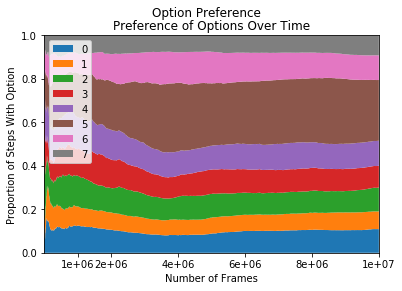

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.01/log_options.csv


<Figure size 432x288 with 0 Axes>

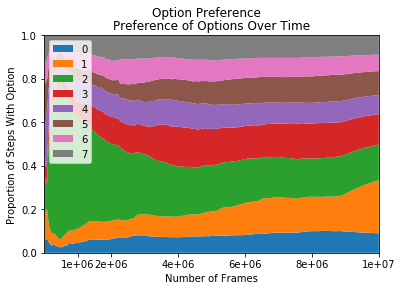

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.015/log_options.csv


<Figure size 432x288 with 0 Axes>

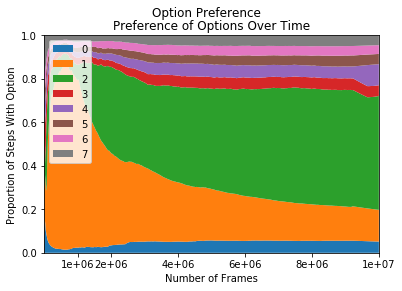

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.02/log_options.csv


<Figure size 432x288 with 0 Axes>

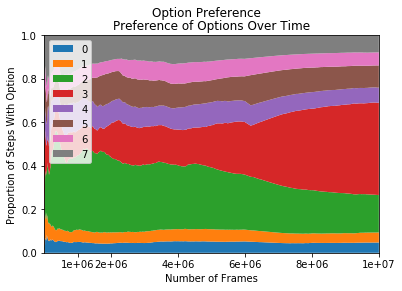

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.025/log_options.csv


<Figure size 432x288 with 0 Axes>

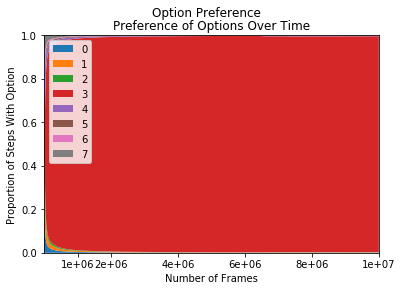

/Users/rsailer/Downloads/save_files/AmidarNoFrameskip-v4_a2oc_8_0.03/log_options.csv


<Figure size 432x288 with 0 Axes>

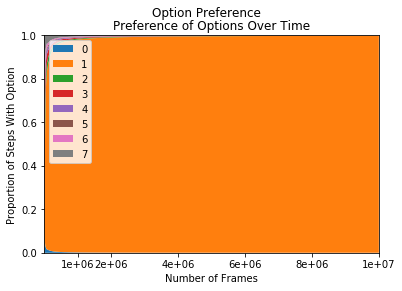

<Figure size 432x288 with 0 Axes>

In [12]:
for f in log_files['Amidar_options']:
    print(f)
    plot_options_preference(f, "Option Preference")

